In [1]:
library(survival)
library(reshape2)
library(tibble)
library(xtable)

## Plotting
library(RColorBrewer)
library(ggplot2)
library(cowplot)
library(pheatmap)
library(pROC)
library(umap)

# library(rgl)
# library(VennDiagram)
# library(UpSetR)
# library(Rtsne)
# library(dendextend)
# library(repr)
# options(repr.plot.width=8, repr.plot.height=4)

theme_set(theme_bw())

## Custom
source("../functions.R")


********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
# FUNCTIONS ---------------------------------------------------------------
#' Get column names in same order as pheatmap plot
#' @param obj pheatmap object
get_colnames <- function(obj) {
  obj$tree_col$labels[obj$tree_col$order]
}

#' Get row names in same order as pheatmap plot
#' @param obj pheatmap object
get_rownames <- function(obj) {
  obj$tree_row$labels[obj$tree_row$order]
}

## Import data

In [141]:
## Metadata
METADATA_RPATH <- "data/GSE67684/processed/metadata/sid-metadata_v2.tsv"
LABEL_RPATH <- "data/GSE67684/processed/metadata/pid-metadata_v4.tsv"
BATCH_RPATH <- "data/GSE67684/processed/metadata/sid-batch.tsv"

metadata_df <- read.table(METADATA_RPATH, sep = "\t")
yeoh_batch <- read.table(BATCH_RPATH, sep = "\t", header = T, row.names = 1)
yeoh_label <- read.table(LABEL_RPATH, sep = "\t", header = T, row.names = 1)
yeoh_label[] <- lapply(yeoh_label, as.factor)

## Subset of original data
# Removed outliers, patients with timepoints from different batches and batch 5
SUBSET_RPATH <- "data/GSE67684/processed/subset_yeoh.tsv"
raw_yeoh <- read.table(SUBSET_RPATH, sep = "\t")
# SCALE->REMOVE->FILTER->LOG
scaled_yeoh <- normaliseMeanScaling(raw_yeoh)
selected_yeoh <- removeProbesets(scaled_yeoh)
data <- log2_transform(filterProbesets(selected_yeoh, 0.7, metadata_df))

  P001_D0   P004_D0   P005_D0   P007_D0   P008_D0   P009_D0 
 5.796952  4.123342  3.981577  6.317643  4.841458 11.978124 
[1] "No. of ambiguous and AFFY probesets removed: 10503"
[1] D0 D0 D0 D0 D0 D0
Levels: D0 D8 N
           D0    D8     N
1053_at  TRUE  TRUE  TRUE
117_at  FALSE  TRUE  TRUE
121_at   TRUE  TRUE  TRUE
1294_at  TRUE  TRUE  TRUE
1316_at  TRUE  TRUE  TRUE
1320_at FALSE FALSE FALSE
[1] "No. of probesets removed = 6321"


In [5]:
yeoh_allps <- log2_transform(scaled_yeoh)
yeoh_unfltr <- log2_transform(selected_yeoh)

#### Day 33

In [6]:
path1 <- "data/leuk_D33/processed/mas5_filtered.tsv"
path2 <- "data/GSE67684/processed/metadata/sid-metadata_v1.tsv"

yeoh_d33 <- read.table(path1, sep = "\t", header = T)
annot_all <- read.table(path2, sep = "\t", header = T)

annot_all[] <- lapply(annot_all, as.factor)
yeoh_d33_allps <- log2_transform(normaliseMeanScaling(yeoh_d33))
# Remove samples that have been curated out of data set
# Members that have been curated out are no longer in annot_all
missing_samples <- colnames(yeoh_d33_allps)[
  !(colnames(yeoh_d33_allps) %in% rownames(annot_all))]
# Remove patients from D33 that have been curated out
yeoh_d33 <- yeoh_d33_allps[
  rownames(data),
  !(colnames(yeoh_d33_allps) %in% missing_samples)
]

P001_D33 P006_D33 P007_D33 P008_D33 P009_D33 P010_D33 
2.106859 2.132480 1.498776 2.559182 1.576584 2.657973 


### Commonly used globals

In [7]:
COL_LABEL <- c("darkolivegreen3", "tomato3")

annot <- metadata_df[colnames(data),]
Y_annot <- annot[,c("batch_info", "label")] # heatmap annot
# Y_all <- all_metadata[colnames(data_all),]

# List subtypes
subtypes9 <- levels(metadata_df$subtype)
subtypes7 <- setdiff(subtypes9, c("Hypodiploid", "Normal"))
subtypes6 <- setdiff(subtypes7, "Others")
subtypes5 <- setdiff(
  subtypes9,
  c("Hypodiploid", "Normal", "Hyperdiploid", "Others")
)
others <- data[, annot$subtype == "Others"]
others_normal <- data[, annot$subtype %in% c("Others", "Normal")]

heatmap_annot <- annot[, c("batch_info", "label"), drop = F]

In [8]:
# Define train/test split
sid_mrd_na <- rownames(yeoh_label)[is.na(yeoh_label$d33_mrd)] %>%
  rep(each = 2) %>%
  paste0(c("_D0", "_D8"))

sid_alltrain_local <- rownames(annot)[
  !(annot$subtype %in% c("Hypodiploid", "Normal")) &
  !(rownames(annot) %in% sid_mrd_na)
]
sid_alltrain <- rownames(annot)[
  !(annot$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(annot) %in% sid_mrd_na)
]
sid_train <- rownames(annot)[
  annot$batch_info %in% 1:7 &
  !(annot$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(annot) %in% sid_mrd_na)
]
sid_test <- rownames(annot)[
  annot$batch_info %in% 8:10 &
  !(annot$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(annot) %in% sid_mrd_na)
]

sid_remission <- rownames(annot)[annot$label == 0]
sid_normal <- paste0("N0", c(1,2,4))

# Identify batch effect probesets

In [121]:
batch_ps <- identify_batch_features(data, annot, method = 'aov')
length(batch_ps)

[1] "No. of NaNs = 16"


[1] 2565

In [11]:
batch_allps <- identify_batch_features(yeoh_allps, annot, method = 'aov')
length(batch_allps)

[1] "No. of NaNs = 5061"


[1] 7504

### Plot: Vectors (UMAP)

In [152]:
# umap_others <- umap(t(others_normal))

In [129]:
# umap_others1 <- cbind(
#   x = umap_others$layout,
#   Y[rownames(umap_others$layout), ]
# )

# umap_others2 <- umap_others1[umap_others1$subtype == "Others", ]
# umap_normal <- umap_others1[umap_others1$subtype == "Normal", ]
# umap_others3 <- umap_others2[seq_len(nrow(umap_others2) / 2), ]
# others_d8 <- umap_others2[seq(nrow(umap_others2) / 2 + 1, nrow(umap_others2)), 1:2]
# umap_others4 <- cbind(umap_others3, others_d8)
# umap_others4 <- umap_others4[, c(1,2,7,8,3:6)]
# colnames(umap_others4)[1:4] <- c("start_x", "start_y", "end_x", "end_y")
# umap_others4$batch_info <- as.factor(umap_others4$batch_info)
# umap_others4$label <- as.factor(umap_others4$label)
# arrow_col <- ifelse(umap_others4$label == 0, "black", "red")

# scatter_pca <- ggplot(data = umap_others4) +
#   geom_point(aes(x = start_x, y = start_y, colour = batch_info),
#              shape = 15, size = cex, show.legend = T) +
#   geom_point(aes(x = end_x, y = end_y, colour = batch_info),
#              shape = 16, size = cex, show.legend = F) +
#   geom_segment(
#     aes(x = start_x, y = start_y, xend = end_x, yend = end_y),
#     arrow = arrow(length = unit(0.3, "cm")),
#     alpha = 0.5,
#     color = arrow_col
#   ) +
#   geom_point(data = umap_normal, aes(x = x.1, y = x.2),
#              size = cex, shape = 17)

# ggsave("~/Dropbox/temp/umap-others.pdf", scatter_pca)

Saving 6.67 x 6.67 in image


## Plot: Vectors (PCA)

In [139]:
# pca_all <- plot_vectors(others, Y)
# ggsave("~/Dropbox/temp/vectors-pca_all.pdf", pca_all)

# others_fltr <- others[!(rownames(others) %in% batch_genes), ]
# pca_wo_batch <- plot_vectors(others_fltr, Y)
# ggsave("~/Dropbox/temp/vectors-pca_wo_batch.pdf")

 [1] 1 1 1 2 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 2 2 2 2 1 2 2
[39] 1 2 1 1 1 1 2 2 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 2 1 2 1 1 1 2 1 1
[77] 1 1 2 1 1 1 1 2 1


Saving 6.67 x 6.67 in image


# Important genes

## Plot: Heatmap

In [16]:
# NAME_GPL570 <- "../info/microarray/HG-U133_Plus_2/annot_genesymbol-GPL570.tsv"
# a_yeoh <- affy2id(yeoh_allps, NAME_GPL570)
# gene_mapping <- affy2id(yeoh_allps, NAME_GPL570, ret.annot = T)

No. of probesets with no ID removed: 1052
Total no. of probesets removed (incl. probesets mapping to same gene): 8762
No. of probesets with no ID removed: 1052
Total no. of probesets removed (incl. probesets mapping to same gene): 8762


In [45]:
# # Selecting CD marker genes
# grep_genes <- grep('^CD[0-9]', rownames(a_yeoh), value = T)
# wrong_genes <- c('CD2BP2', 'CD2AP', 'CD3EAP', 'CD5L', 'CD40LG')
# cd_genes <- setdiff(grep_genes, wrong_genes)

# yeoh_cd <- a_yeoh[cd_genes, ]
# # all_cd <- ann_yeoh2[cd_genes, ] # Includes D33 samples

# # Rename genes with multiple names
# rename_genes <- c('CD8B', 'CD68', 'CD302')
# for (gene in rename_genes) {
#   rownames(yeoh_cd)[grep(gene, rownames(yeoh_cd))] <- gene
# }
# # for (gene in rename_genes) {
# #   rownames(all_cd)[grep(gene, rownames(all_cd))] <- gene
# # }

## B-ALL "Others" subtypes
- DUX4
    - Overexpression of DUX4
    - Characterised by recurrent IGH-DUX4 or ERG-DUX4 fusions
    - Frequently co-occurring with intragenic ERG deletions
- PAX5alt
    - PAX5 as a driver mutation
    - Commonly have co-deletion of IKZF1 and CDKN2A/B
    - If IKZF1 is deleted, poor outcome. Otherwise, excellent prognosis
- ETV6-RUNX1-like
    - ETV6 and IKZF1 alterations
    - IKZF1 alterations did not result in poor prognosis, unlike other cases in B-ALL
- ZNF384-like
- BCR-ABL1-like
    - No CRLF2 rearrangement

### Plot: UMAP

In [255]:
# exclude batch effect genes
d0_wo_batch <- data[
  !(rownames(data) %in% batch_genes),
  Y[colnames(data), "class_info"] == "D0"
]
d0_hvg500 <- select_hvg(d0_wo_batch, 500)

In [660]:
umap_obj <- umap(t(d0_hvg500))
umap_d0_hvg500 <- plot_umap(umap_obj, Y, col = "subtype", pch = "label")
# ggsave("~/Dropbox/temp/umap-d0_hvg500.pdf", umap_d0_hvg500, width = 7, height = 4)

           UMAP1       UMAP2 subtype label
P001_D0 3.264515  0.29340424   T-ALL     0
P004_D0 2.678722 -0.52931064   T-ALL     0
P005_D0 2.635956 -0.33556299   T-ALL     0
P007_D0 2.928077 -0.06792923   T-ALL     1
P008_D0 3.365494  0.42612226   T-ALL     0
P009_D0 2.613520 -1.36106373   T-ALL     0


## Plot: PCA

In [18]:
# plot_pca(d0_hvg500, Y, col = "subtype")
# ggsave("~/Dropbox/temp/pca-d0_hvg500.pdf", pca_d0_hvg500, width = 7, height = 4)

# Identify novel subtypes in B-Others

#### Original figures:
- Batch effect ps: data
- Annotated data: yeoh_unfltr
- Gene mapping: yeoh_unfltr

## Yeoh (2002): Subtype gene signatures

In [14]:
NAME_GPL570 <- "../info/microarray/HG-U133_Plus_2/annot_genesymbol-GPL570.tsv"
a_data <- affy2id(data, NAME_GPL570)
a_unfltr <- affy2id(yeoh_unfltr, NAME_GPL570)
a_allps <- affy2id(yeoh_allps, NAME_GPL570)

No. of probesets with no ID removed: 130
Total no. of probesets removed (incl. probesets mapping to same gene): 714
No. of probesets with no ID removed: 819
Total no. of probesets removed (incl. probesets mapping to same gene): 2559
No. of probesets with no ID removed: 1052
Total no. of probesets removed (incl. probesets mapping to same gene): 8762


In [15]:
gene_mapping1 <- affy2id(yeoh_unfltr, NAME_GPL570, ret.annot = T)
gene_mapping2 <- affy2id(yeoh_allps, NAME_GPL570, ret.annot = T)

No. of probesets with no ID removed: 819
Total no. of probesets removed (incl. probesets mapping to same gene): 2559
No. of probesets with no ID removed: 1052
Total no. of probesets removed (incl. probesets mapping to same gene): 8762


In [16]:
PS_RPATH1 <- "data/yeoh_2002/README/chi_square_probesets/combined.tsv"
PS_RPATH2 <- "../info/microarray/HG-U95Av2/HG_U95Av2-GEO_annot.tsv"

# Gene signatures selected by chi2 feature selection in Yeoh (2002)
ps_info <- read.table(
  PS_RPATH1, sep = "\t", header = T,
  quote = "", na.strings = " ", stringsAsFactors = F
)
# Affy95 probeset annotations
u95av2_annot <- read.table(
  PS_RPATH2, sep = "\t", header = T,
  row.names = 1, stringsAsFactors = F
)

In [17]:
# Gene signatures from Yeoh (2002)
chisq_ps <- ps_info$affymetrix # [grepl("[gis]_at", ps_info$affymetrix)]
chisq_genes <- u95av2_annot[chisq_ps, "Gene.Symbol"]
chisq_genes <- unique(chisq_genes)

In [18]:
# Get all GPL570 probesets without batch effect probesets
batch_genes <- gene_mapping2[batch_allps]
batch_genes <- batch_genes[!(is.na(batch_genes))]
nonbatch_genes <- setdiff(rownames(a_allps), batch_genes)

[1] 9047


In [19]:
#' Find similar genes to vector of gene symbols
#' @return named list with gene symbols in x as names and
#' matching gene symbols in y as values
get_similar_genes <- function(x, y) {
  # Default value of gene with no match is NULL
  matched_genes <- vector("list", length(x))
  names(matched_genes) <- x
  
  idx_notequiv <- !(x %in% y)
  not_equiv <- x[idx_notequiv]
  idx_mult <- grepl("///", not_equiv)
  
  matched_singles <- lapply(
    not_equiv[!idx_mult],
    grep, x = y, value = T
  )
  names(matched_singles) <- not_equiv[!idx_mult]
  matched_singles_fltr <- Filter(
    function(x) ifelse(length(x) == 0, F, T),
    matched_singles
  )

  mult_symbols <- lapply(
    not_equiv[idx_mult],
    function(x) unlist(strsplit(x, " /// "))
  )
  names(mult_symbols) <- not_equiv[idx_mult]
  matched_mults <- lapply(
    mult_symbols,
    function(x) unlist(lapply(x, grep, x = y, value = T))
  )
  matched_mults_fltr <- Filter(
    function(x) ifelse(length(x) == 0, F, T),
    matched_mults
  )
  
  # initialise list with equivalent genes
  matched_genes[!idx_notequiv] <- x[!idx_notequiv]
  # replace similar singles and multiples
  matched_genes[names(matched_singles_fltr)] <- matched_singles_fltr
  matched_genes[names(matched_mults_fltr)] <- matched_mults_fltr

  matched_genes
}

In [20]:
matched_genes <- get_similar_genes(chisq_genes, nonbatch_genes)
matched_genes <- Filter(function(x) !is.null(x), matched_genes)
similar_genes <- matched_genes[!(names(matched_genes) == matched_genes)]

del_genes <- names(similar_genes)[-c(5, 6, 8, 11)]
mod_genes <- names(similar_genes)[c(5, 6, 8, 11)]

# Keep all genes with multiple mappings
matched_genes_fltr <- matched_genes[!(names(matched_genes) %in% del_genes)]
gene_signatures <- unique(do.call(c, matched_genes_fltr))

In [23]:
# All D0 samples
ayeoh_fltr <- a_allps[
  gene_signatures,
  annot[colnames(a_allps), "class_info"] == "D0"
]
# ayeoh_fltr <- ayeoh_fltr[rowSums(ayeoh_fltr) != 0, ]

In [24]:
# Select top 50 HVG from signatures
ayeoh_fltr1 <- select_hvg(ayeoh_fltr, 50)

In [55]:
# Heatmap settings
heatmap_annot <- annot[, "subtype", drop = F]
colnames(heatmap_annot) <- "Subtype"

# set1_colours <- ggplot_palette(9)
set1_colours <- brewer.pal(n = 9, name = "Set1")
names(set1_colours) <- rev(levels(heatmap_annot$Subtype))
annot_colours <- list(Subtype = set1_colours) 

In [58]:
yeoh2002_hclust <- pheatmap(
  ayeoh_fltr1,
  col = brewer.pal(n = 11, name = "RdBu"),
  display_numbers = F, legend = T, border_color = NULL,
  cluster_method = "complete", cluster_rows = T, cluster_cols = T,
  clustering_distance_rows = "euclidean", clustering_distance_cols = "euclidean",
  scale = "row", show_colnames = F, show_rownames = F,
  annotation = heatmap_annot, annotation_colors = annot_colours,
  fontsize = 12, cellwidth = 2.5, cellheight = 3.5,
  filename = "~/Dropbox/tmp/heatmap-yeoh_signature.pdf"
)

In [26]:
# pid <- get_colnames(yeoh2002_hclust)
# pid_subtype <- annot[pid, 'subtype']
# names(pid_subtype) <- pid
# which(names(pid_subtype) == 'P092_D0')
# which(names(pid_subtype) == 'P203_D0')
# pid_subtype[73:94]

#### Confirm DUX4 genes

In [869]:
# top50_hvg_sig <- get_rownames(all_signatures1)
# dux4_genes <- top50_hvg_sig[26:32]
# chisq_genes1 <- u95av2_annot[chisq_ps, "Gene.Symbol", drop = F]

In [874]:
# dux4_ps <- rownames(chisq_genes1)[chisq_genes1$Gene.Symbol %in% dux4_genes]
# print(dux4_ps)

[1] "31892_at" "994_at"   "995_g_at" "37542_at" "36029_at" "41708_at" "1664_at" 
[8] "1731_at"  "33037_at"


In [886]:
# rpath <- "data/yeoh_2002/README/chi_square_probesets/novel.txt"
# novel_ps <- read.table(
#   rpath, sep = "\t", row.names = 2,
#   stringsAsFactors = F, quote = "",
# )

#### Plot: UMAP

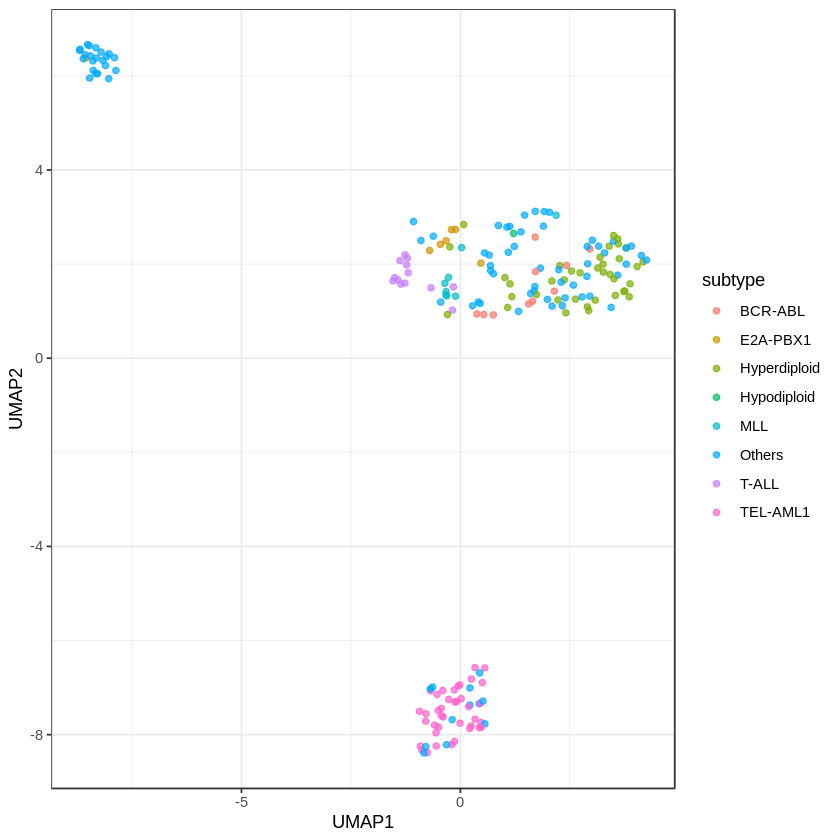

In [44]:
umap_obj <- umap(t(ayeoh_fltr1))
umap_ayeoh_fltr <- plot_umap(
  umap_obj, annot,
  cex = 1.5, alpha = .7, color = 'subtype'
) +
  labs(col = "subtype")

wpath <- "~/Dropbox/temp/umap-yeoh_signature.pdf"
# ggsave(wpath, umap_ayeoh_fltr, width = 6, height = 3)

umap_ayeoh_fltr

#### Identify DUX4 patients

In [45]:
# DUX4 cluster (w/ E2A-PBX1)
z_umap <- umap_obj$layout
others_cluster <- z_umap[z_umap[, 2] > 4, ]

subtype_others_cluster <- annot[rownames(others_cluster), , drop = F]
dux4_subtype <- subtype_others_cluster[
  subtype_others_cluster$subtype == "Others", , drop = F]
sid_dux4_cluster <- rownames(dux4_subtype)
print(sid_dux4_cluster)

 [1] "P060_D0" "P063_D0" "P071_D0" "P073_D0" "P076_D0" "P077_D0" "P083_D0"
 [8] "P087_D0" "P090_D0" "P092_D0" "P105_D0" "P108_D0" "P111_D0" "P123_D0"
[15] "P143_D0" "P173_D0" "P174_D0" "P177_D0" "P201_D0" "P203_D0" "P212_D0"
[22] "P215_D0"


In [284]:
# Colnames from hclust
hclust_colnames <- get_colnames(yeoh2002_hclust)
sid_hclust <- hclust_colnames[73:94]
sid_dux4_hclust <- sid_hclust[annot[sid_hclust, "subtype"] == 'Others']
sid_dux4_hclust

[1] "P092_D0" "P108_D0" "P060_D0" "P212_D0" "P105_D0" "P215_D0" "P173_D0"
 [8] "P143_D0" "P174_D0" "P071_D0" "P201_D0" "P083_D0" "P076_D0" "P087_D0"
[15] "P063_D0" "P111_D0" "P073_D0" "P077_D0" "P090_D0" "P177_D0" "P203_D0"

In [286]:
print(length(sid_dux4_cluster))
print(length(sid_dux4_hclust))

sid_dux4_d0 <- intersect(sid_dux4_cluster, sid_dux4_hclust)
sid_dux4_d8 <- paste0(substring(sid_dux4_d0, 1, 4), "_D8")
sid_dux4 <- c(sid_dux4_d0, sid_dux4_d8)
print(sid_dux4_d0)

[1] 22
[1] 21
 [1] "P060_D0" "P063_D0" "P071_D0" "P073_D0" "P076_D0" "P077_D0" "P083_D0"
 [8] "P087_D0" "P090_D0" "P092_D0" "P105_D0" "P108_D0" "P111_D0" "P143_D0"
[15] "P173_D0" "P174_D0" "P177_D0" "P201_D0" "P203_D0" "P212_D0" "P215_D0"


### Identify TEL-AML1-like patients

In [105]:
z_umap <- umap_obj$layout
# TEL-AML1 cluster
telaml1_cluster <- z_umap[z_umap[, 2] < -5, ]
subtype_telaml1_cluster <- annot[rownames(telaml1_cluster), "subtype", drop = F]
telaml1_like <- subtype_telaml1_cluster[
  subtype_telaml1_cluster$subtype == "Others", , drop = F]
sid_telaml1_like_d0 <- rownames(telaml1_like)

In [95]:
# Order of PID from hierarchical clustering
ordered_colnames <- annot[get_colnames(yeoh2002_hclust), "subtype"]
names(ordered_colnames) <- get_colnames(yeoh2002_hclust)
sid_telaml1_hclust <- names(ordered_colnames)[95:145]

# All the patients present in the UMAP cluster cluster together in hclust
# sum(sid_telaml1_like %in% sid_telaml1_hclust)
# length(sid_telaml1_like)

#### Identify BCR-ABL-like patients

In [54]:
# Naive row-wise two-sample t-test for every probe
# Does a t-test between every row of matrices a and b
# Arguments: Dataframe with both clases, size of class A, ...
#' @param paired logical indicating whether X contains paired data or not
calc_univariate <- function(
  FUN, X, Y = NULL, n = NULL, paired = FALSE, 
  flag = "p.value"
) {
  if (paired) {
    # Y and n can be both NULL    
    n <- ncol(X) / 2
  }
  
  if (!is.null(Y)){
    if (!is.data.frame(X) | !is.data.frame(Y))
      stop("Type error: Both X and Y have to be of class data.frame.")
    list_htest <- mapply(FUN, data.frame(t(X)), data.frame(t(Y)), SIMPLIFY = F)
  } else if(!is.null(n)) {
    print(n)
    list_htest <- apply(
      X, 1,
      function(x) FUN(x[1:n], x[-(1:n)], paired = paired)
    )
  } else {
    stop("If paired is FALSE either Y or n must be provided.")   
  }
  
  if (flag == "p.value") {
    return(sapply(list_htest, function(obj) obj$p.value))
  } else if (flag == "statistic") {
    return(sapply(list_htest, function(obj) obj$statistic))
  } else {
    return(list_htest)
  }
}


In [202]:
# # Remove batch effect ps
# d0_fltr <- data[
#   !(rownames(data) %in% batch_ps),
#   Y[colnames(data), "class_info"] == "D0"
# ]

# ALPHA <- .01
# M <- 50
# # Feature selection: For each of the 6 subtypes
# all_ps <- data.frame()
# for (subtype in subtypes6) {
#   idx_subtype <- Y[colnames(d0_fltr), "subtype"] == subtype
#   d0_subtype <- d0_fltr[, idx_subtype]
#   d0_rest <- d0_fltr[, !idx_subtype]
#   row_pvalue <- calc_univariate(wilcox.test, d0_subtype, d0_rest)
  
#   idx_num <- which(rank(row_pvalue) <= M)
#   sig_ps <- rownames(d0_fltr)[idx_num] # OPTION: Top M
# #   sig_ps <- rownames(d0_fltr)[row_pvalue < ALPHA]   # OPTION: pvalue
  
#   subtype_ps <- data.frame(probesets = sig_ps, subtype = subtype)
#   all_ps <- rbind(all_ps, subtype_ps)
# }
# all_ps$probesets <- as.character(all_ps$probesets)

In [192]:
# ps_bcrabl <- all_ps$probesets[all_ps$subtype == "BCR-ABL"] # OPTION!
# d0_fltr1 <- d0_fltr[ps_bcrabl, ]
# d0_fltr2 <- select_hvg(d0_fltr1, 150)

# heatmap_annot1 <- Y[, c("subtype", "batch_info", "label")]
# heatmap_annot1$batch_info <- as.numeric(as.character(heatmap_annot1$batch_info))
# heatmap_annot1$label <- as.numeric(as.character(heatmap_annot1$label))

# hm <- pheatmap(
#   d0_fltr1,
#   col = brewer.pal(n = 11, name = "RdBu"),
# #   col = brewer.pal(9, "Blues"),
#   display_numbers = F, legend = T, border_color = NULL,
#   cluster_method = "complete", cluster_rows = T, cluster_cols = T,
#   clustering_distance_rows = "euclidean", clustering_distance_cols = "euclidean",
# #   cutree_cols = 4,
#   scale = "row", show_colnames = T, show_rownames = F,
#   annotation_col = heatmap_annot1,
#   fontsize = 6, cellwidth = 7, cellheight = 10,
#   filename = "~/Dropbox/temp/heatmap-d0_ttest_bcrabl.pdf"
# )

### Identify BCR-ABL-like patients (high expression genes)

In [506]:
# Remove batch effect ps
d0_fltr <- data[
  !(rownames(data) %in% batch_ps),
  Y[colnames(data), "class_info"] == "D0"
]

# Feature selection: BCR-ABL only
idx_subtype <- Y[colnames(d0_fltr), "subtype"] == "BCR-ABL"
d0_subtype <- d0_fltr[, idx_subtype]
d0_rest <- d0_fltr[, !idx_subtype]
row_pvalue <- calc_univariate(wilcox.test, d0_subtype, d0_rest)
names(row_pvalue) <- substring(names(row_pvalue), 2)

# Select highly expressed probesets in BCR-ABL
EXPR <- 6
mu_bcrabl <- rowMeans(d0_subtype)
ps_high <- names(mu_bcrabl)[mu_bcrabl > EXPR]
pvalue_fltr <- row_pvalue[ps_high]

M <- 300
ps_bcrabl <- names(pvalue_fltr)[rank(pvalue_fltr) <= M]

In [512]:
# Wilcoxon - Top 300 pvalue
d0_fltr_heg <- d0_fltr[ps_bcrabl, ]
pheatmap(
  d0_fltr_heg,
  col = brewer.pal(n = 11, name = "RdBu"),
#   col = brewer.pal(9, "Blues"),
  display_numbers = F, legend = T, border_color = NULL,
  cluster_method = "complete", cluster_rows = T, cluster_cols = T,
  clustering_distance_rows = "euclidean", clustering_distance_cols = "euclidean",
#   cutree_cols = 4,
  scale = "row", show_colnames = T, show_rownames = F,
  annotation_col = heatmap_annot1,
  fontsize = 6, cellwidth = 7, cellheight = 2,
  filename = "~/Dropbox/temp/heatmap-heg_wilcox300_bcrabl.pdf"
)

In [463]:
# d0_fltr2 <- select_hvg(d0_fltr1, 150)

obj <- umap(t(d0_fltr_heg))
ax_umap <- plot_umap(obj, Y, col = "subtype")
wpath <- "~/Dropbox/temp/umap-heg_wilcox300_bcrabl.pdf"
ggsave(wpath, ax_umap, width = 7, height = 4)

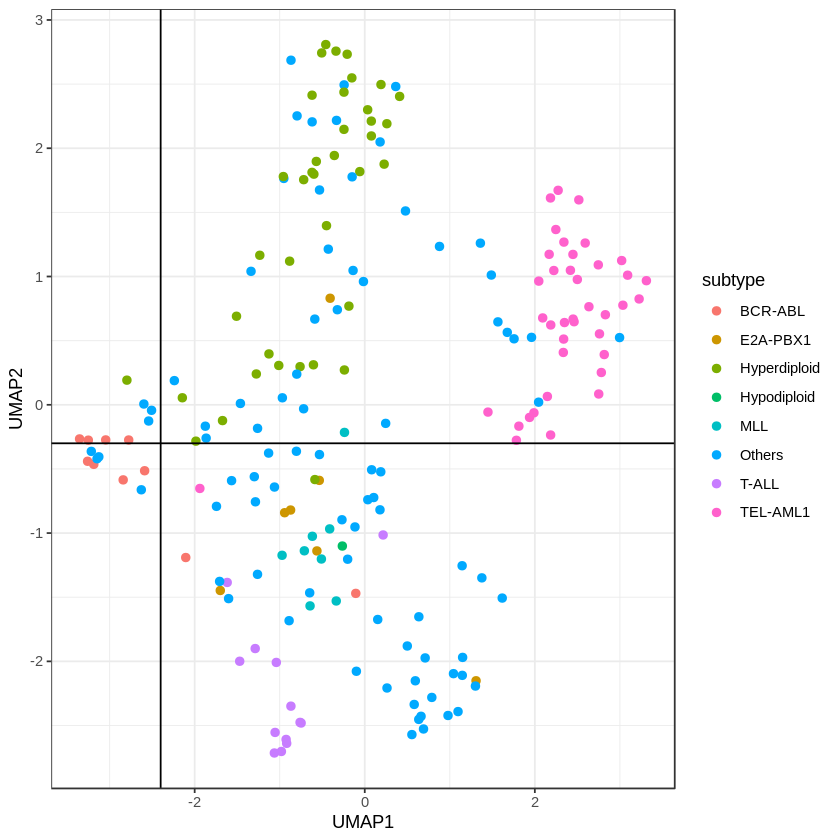

In [464]:
THRESHOLD1 <- -2.4
THRESHOLD2 <- -0.3

ax_umap +
  geom_vline(xintercept = THRESHOLD1) +
  geom_hline(yintercept = THRESHOLD2)

In [465]:
z_umap <- obj$layout
sid <- rownames(z_umap)[z_umap[, 1] < THRESHOLD1 & z_umap[, 2] < THRESHOLD2]
sid_bcrabl_like_d0 <- sid[Y[sid, "subtype"] == "Others"]
sid_bcrabl_like_d8 <- paste0(substring(sid_bcrabl_like_d0, 1, 4), "_D8")
sid_bcrabl_like <- c(sid_bcrabl_like_d0, sid_bcrabl_like_d8)

#### Identify TEL-AML1 outlier

In [470]:
# Remove batch effect ps
d0_fltr <- data[
  !(rownames(data) %in% batch_ps),
  Y[colnames(data), "class_info"] == "D0"
]

ALPHA <- .01
M <- 50
# Feature selection: For each of the 6 subtypes
all_ps <- data.frame()
for (subtype in subtypes6) {
  idx_subtype <- Y[colnames(d0_fltr), "subtype"] == subtype
  d0_subtype <- d0_fltr[, idx_subtype]
  d0_rest <- d0_fltr[, !idx_subtype]
  row_pvalue <- calc_univariate(wilcox.test, d0_subtype, d0_rest)
  
  idx_num <- which(rank(row_pvalue) <= M)
  sig_ps <- rownames(d0_fltr)[idx_num] # OPTION: Top M
#   sig_ps <- rownames(d0_fltr)[row_pvalue < ALPHA]   # OPTION: pvalue
  
  subtype_ps <- data.frame(probesets = sig_ps, subtype = subtype)
  all_ps <- rbind(all_ps, subtype_ps)
}
all_ps$probesets <- as.character(all_ps$probesets)

In [478]:
d0_fltr1 <- d0_fltr[all_ps$probesets, ]
umap_obj <- umap(t(d0_fltr1))
ax_umap <- plot_umap(umap_obj, Y, col = 'subtype')
ggsave('~/Dropbox/temp/umap-d0_wilcox.pdf', ax_umap, width = 7, height = 4)

In [479]:
z_umap <- umap_obj$layout
sid <- rownames(z_umap)[z_umap[, 1] > -1]
sid_outlier <- sid[Y[sid, 'subtype'] == 'TEL-AML1']
sid_outlier

[1] "P023_D0"

#### Identify BCR-ABL-like patients

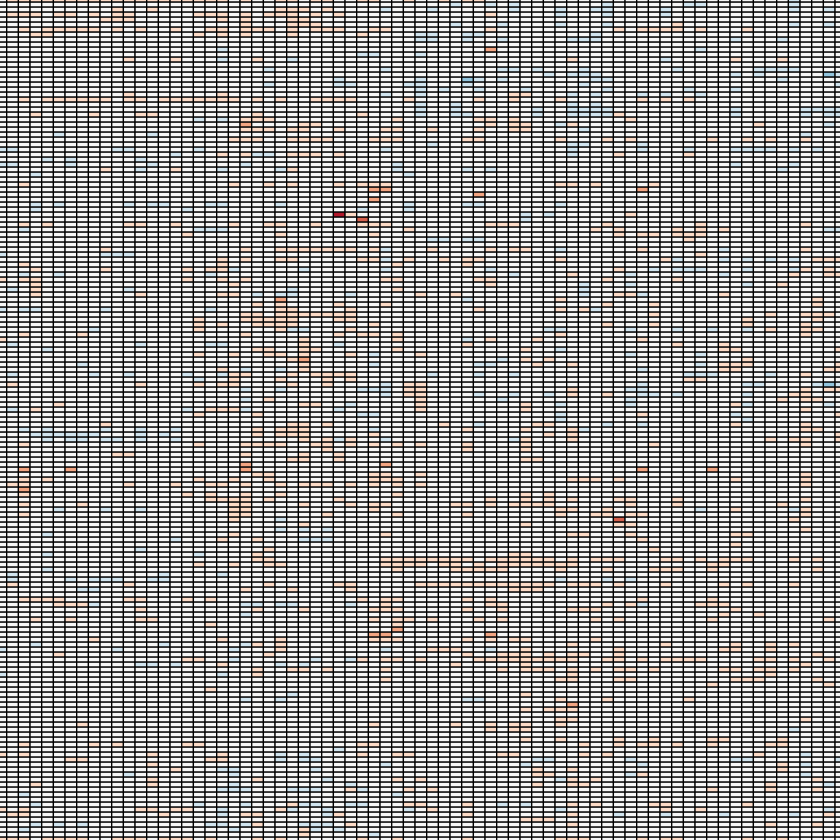

In [356]:
# M <- 300
# ps_bcrabl <- names(row_pvalue)[rank(row_pvalue) <= M]
# d0_fltr1 <- d0_fltr[ps_bcrabl, ]

# hmap <- pheatmap(
#   d0_fltr1,
#   col = brewer.pal(n = 11, name = "RdBu"),
# #   col = brewer.pal(9, "Blues"),
#   display_numbers = F, legend = T, border_color = NULL,
#   cluster_method = "complete", cluster_rows = T, cluster_cols = T,
#   clustering_distance_rows = "euclidean", clustering_distance_cols = "euclidean",
# #   cutree_cols = 4,
#   scale = "row", show_colnames = T, show_rownames = F,
#   annotation_col = heatmap_annot1,
#   fontsize = 6, cellwidth = 7, cellheight = 3,
  
# )

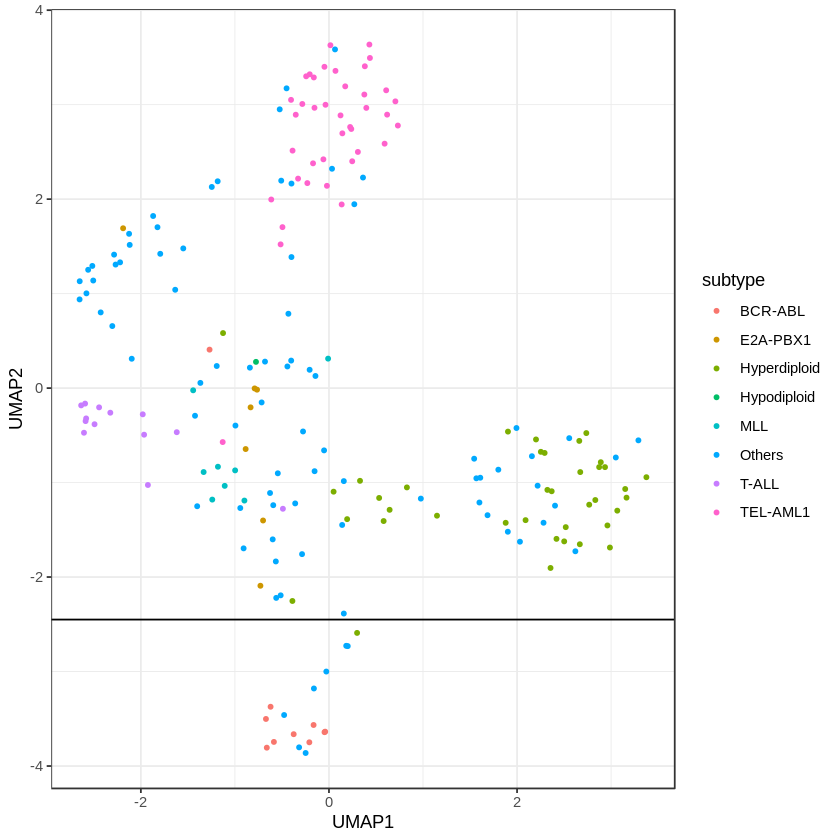

In [394]:
obj <- umap(t(d0_fltr1))
ax_umap <- plot_umap(obj, Y, cex = 1, col = "subtype")

THRESHOLD <- -2.45
ax_umap + geom_hline(yintercept = THRESHOLD)

sid_fltr <- rownames(obj$layout)[obj$layout[, 2] < THRESHOLD]
sid_bcrabl_like_d0 <- sid_fltr[Y[sid_fltr, "subtype"] == "Others"]

hmap_colnames <- get_colnames(hmap)
# which(hmap_colnames %in% sid_others)
sid_bcrabl_like_d8 <- paste0(substring(sid_bcrabl_like_d0, 1, 4), "_D8")
sid_bcrabl_like_all <- c(sid_bcrabl_like_d0, sid_bcrabl_like_d8)

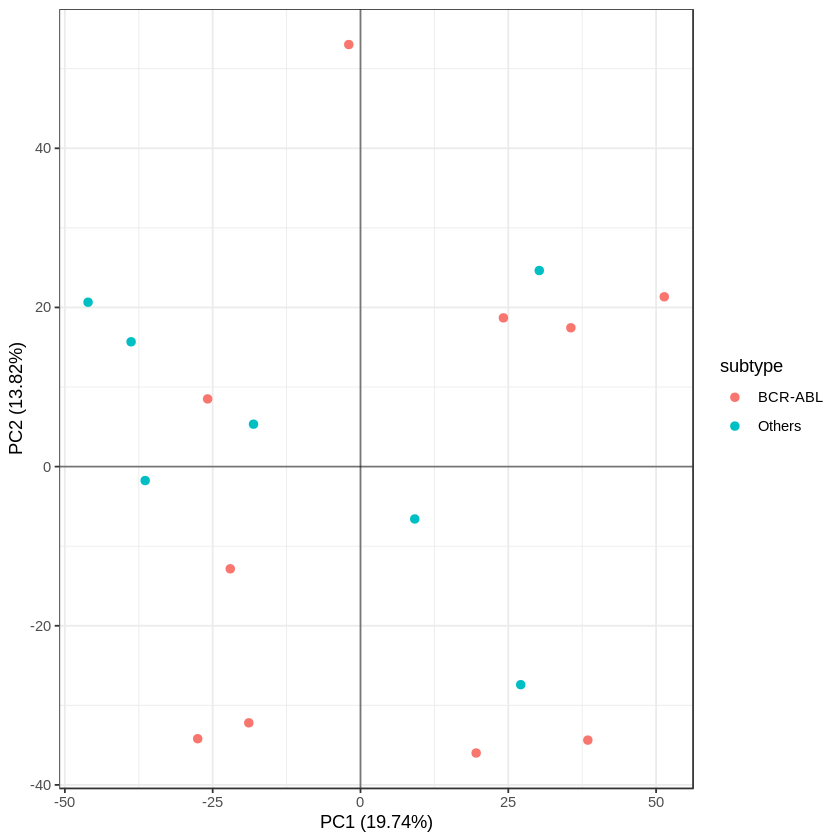

In [400]:
# Plot UMAP of BCR-ABL and BCR-ABL-like
idx_bcrabl_d0 <- Y[colnames(data), "subtype"] == "BCR-ABL" &
  Y[colnames(data), "class_info"] == "D0"

sid_bcrabl_d0 <- colnames(data)[idx_bcrabl_d0]
sid_d0 <- c(sid_bcrabl_d0, sid_bcrabl_like_d0)

all_bcrabl <- select_hvg(data[, sid_d0], 300)
obj <- umap(t(all_bcrabl))
# plot_umap(obj, Y, col = "subtype")
plot_pca(all_bcrabl, Y, col = "subtype")

#### Use BCR-ABL signature from Yeoh et al. (2002)

In [76]:
PS_RPATH1 <- "data/yeoh_2002/README/chi_square_probesets/BCR-ABL.txt"
PS_RPATH2 <- "../info/microarray/HG-U95Av2/HG_U95Av2-GEO_annot.tsv"
# Gene signatures selected by chi2 feature selection in Yeoh (2002)
ps_bcrabl_info <- read.table(
  PS_RPATH1, sep = "\t", header = F,
  quote = "", na.strings = " ", stringsAsFactors = F
)
# Affy95 probeset annotations
u95av2_annot <- read.table(
  PS_RPATH2, sep = "\t", header = T,
  row.names = 1, stringsAsFactors = F
)

In [ ]:
# Matched annotations
gene_symbols <- affy2id(yeoh_unfltr, NAME_GPL570, ret.annot = T)

In [91]:
ps_bcrabl <- ps_bcrabl_info[, 2]
genes_bcrabl <- u95av2_annot[ps_bcrabl, "Gene.Symbol"]
genes_bcrabl_1 <- genes_bcrabl[genes_bcrabl %in% gene_symbols]

# Remove batch effect genes
batch_genes <- gene_symbols[batch_ps]
batch_genes <- batch_genes[!(is.na(batch_genes))]
nonbatch_genes <- setdiff(rownames(ann_yeoh), batch_genes)
genes_bcrabl_2 <- setdiff(genes_bcrabl_1, nonbatch_genes)

In [106]:
hmap <- pheatmap(
  ann_yeoh[genes_bcrabl_2, endsWith(colnames(ann_yeoh), "_D0")],
  col = brewer.pal(n = 11, name = "RdBu"),
#   col = brewer.pal(9, "Blues"),
  display_numbers = F, legend = T, border_color = NULL,
  cluster_method = "complete", cluster_rows = T, cluster_cols = T,
  clustering_distance_rows = "euclidean", clustering_distance_cols = "euclidean",
#   cutree_cols = 4,
  scale = "row", show_colnames = T, show_rownames = F,
  annotation_col = heatmap_annot1,
  fontsize = 6, cellwidth = 7, cellheight = 40,
  filename = "~/Dropbox/temp/heatmap-d0_bcrabl_yeoh1.pdf"
)

# Latest

In [34]:
# exclude batch effect genes
d0_wo_batch <- data[
  !(rownames(data) %in% batch_ps),
  annot[colnames(data), 'class_info'] == 'D0'
]
d0_others <- d0_wo_batch[
  , annot[colnames(d0_wo_batch), 'subtype'] == 'Others']

hvg <- select_hvg(d0_others, 300, ret.genes = T)
umap_obj <- umap(t(d0_wo_batch[hvg, ]))
ax <- plot_umap(umap_obj, annot, color = 'subtype')
ggsave('~/Dropbox/tmp/umap-others_hvg500.pdf', ax,
       width = 9, height = 5)
# plot_pca(d0_wo_batch[hvg, ], annot, color = 'subtype')

## Plot: Boxplots

In [102]:
#' Plots boxplot of features, p_rem WITHOUT global ERM
#' Provides p-values from wilcoxon rank-sum test
plot_boxplots <- function(X_y) {
  FEAT_ORDER <- c(
    "erm1_ratio2", "l2norm_ratio2", "angle_d0d8_d0normal",
    "log_mrd", "p_rem"
  )
  FEAT_LABS <- c(
    "'ERM Ratio'", "'ARM Ratio'", "theta",
    "log[10](MRD)", "paste('P(Remission|', bold(x), ', s)')"
  )
  
  long_X_y <- melt(X_y, id = "label", variable.name = "feature")
  # Reorder levels and label features
  long_X_y$feature <- factor(
    long_X_y$feature,
    levels = FEAT_ORDER,
    labels = FEAT_LABS
  )
  levels(long_X_y$label) <- c("Remission", "Relapse")
  
  ax_jitter <- ggplot(
    long_X_y,
    aes(x = label, y = value)
  ) +
    geom_boxplot(
      aes(group = label),
      col = "black", alpha = 0,
      show.legend = F
    ) +
    geom_point(
      aes(fill = label),
      position = position_jitterdodge(jitter.width = 1),
      cex = 2.5, pch = 21, alpha = 1,
      col = "black", show.legend = F
    ) +
    scale_fill_manual(values = COL_LABEL) +
    facet_wrap(
      ~feature,
      nrow = 1, scales = "free",
      labeller = label_parsed
    ) +
    theme(
      axis.title.x = element_blank(),
      axis.text.x = element_text(angle = 15),
      axis.title.y = element_blank(),
      legend.position = "none"
    )
  
  # Jitter plot: p-value label
  # Both group sizes must be > 1
  if (length(table(X_y$label)) > 1 && min(table(X_y$label)) > 1) {
    p_labs <- sapply(
      FEAT_ORDER,
      function(idx) {
        list_feat <- split(X_y[, idx], X_y$label)
        tryCatch(
          {
            htest <- wilcox.test(
              list_feat[[1]], list_feat[[2]], exact  = T
            )
            sprintf("p = %.3f", htest$p.value)
          },
          error = function(err) {
            print(err)
            return(err)
          }
        )
      }
    )
    
    ann_text <- data.frame(
      feature = factor(
        FEAT_ORDER,
        levels = FEAT_ORDER,
        labels = FEAT_LABS
      ),
      value = c(
        max(X_y[FEAT_ORDER[1]]),
        max(X_y[FEAT_ORDER[2]]),
        min(X_y[FEAT_ORDER[3]]),        
        min(X_y[FEAT_ORDER[4]]),
        max(X_y[FEAT_ORDER[5]])
      ),
      lab = p_labs
    )
    ann_text <- na.omit(ann_text)
    print(ann_text$feature)

    ax_jitter <- ax_jitter +
      geom_text(
        data = ann_text,
        aes(x = 1.5, y = value, label = lab),
        size = 3, # colour = "black",
        hjust = 0
      )
  }
  
  ax_jitter
}

### Evaluate with DUX4 (all train)

In [304]:
X_dux4 <- data[, sid_dux4]
X_normal <- data[, sid_normal]
dux4_pred <- predict_pipeline(
  X_dux4, X_normal,
  annot, yeoh_label,
  batch_ps
)

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 772"
[1] "No. of features (p-value) = 2564"
[1] "No. of features (log2-fc) = 679"
[1] "No. of selected genes = " "660"                     
[1] "No. of final genes = " "480"                  
 [1] "P060_D0" "P063_D0" "P071_D0" "P073_D0" "P076_D0" "P077_D0" "P083_D0"
 [8] "P087_D0" "P090_D0" "P092_D0" "P105_D0" "P108_D0" "P111_D0" "P143_D0"
[15] "P173_D0" "P174_D0" "P177_D0" "P201_D0" "P203_D0" "P212_D0" "P215_D0"
[1] "NO. OF SAMPLES IN CENTROID: 19"


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

[1] 'ERM Ratio'                           
[2] 'ARM Ratio'                           
[3] theta                                 
[4] log[10](MRD)                          
[5] paste('P(Remission|', bold(x), ', s)')
5 Levels: 'ERM Ratio' 'ARM Ratio' theta ... paste('P(Remission|', bold(x), ', s)')


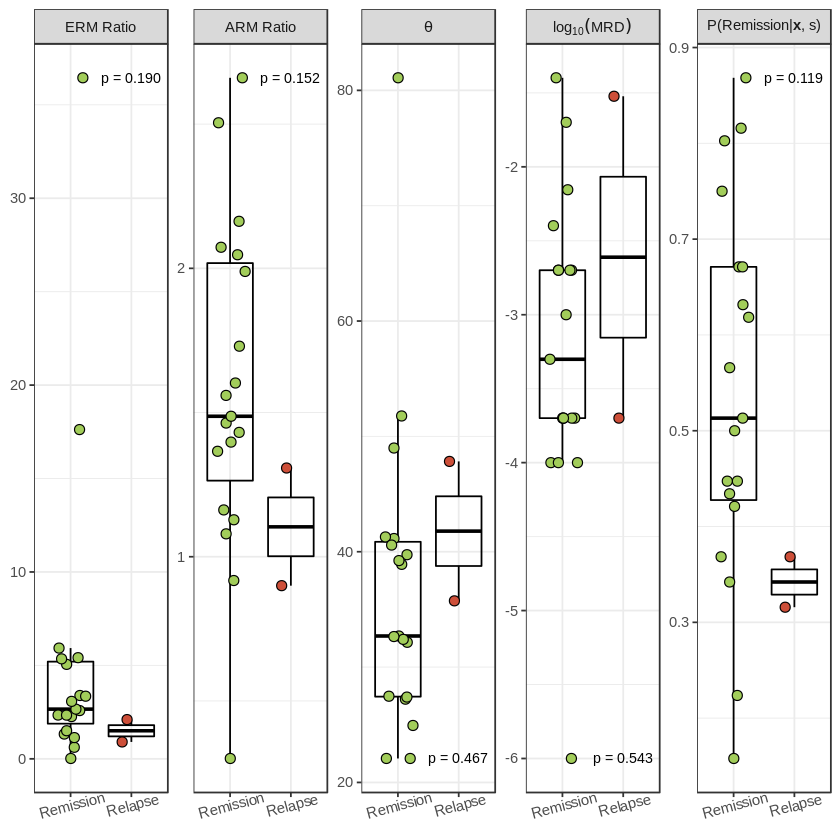

In [306]:
plot_boxplots(dux4_pred$X_y)

In [103]:
#' Predict each subtype with train/test split
#' ASSUME: sid_train and sid_test contain no patients with NA MRD values
#' @param subtype string indicating subtype
predict_pipeline_test <- function(
  sid_subtype, X_normal,
  metadata, metadata_mrd,
  sid_train, sid_test,
  batch_genes,
  sid_remission, sid_normal, X
) {  
  sid_subtype_train <- intersect(sid_subtype, sid_train)
  sid_subtype_test <- intersect(sid_subtype, sid_test)
  
  subtype_train <- X[, sid_train, drop = F]
  subtype_test <- X[, sid_test, drop = F]
  
  ## Feature selection using train set
  class_genes <- getLocalGenes(subtype_train, sid_remission)
  selected_genes <- setdiff(class_genes, batch_genes)
  
  print(c("No. of class genes = ", length(class_genes)))
  print(c("No. of selected genes = ", length(selected_genes)))
  
  # Subtype and normal samples
  response <- t(X[selected_genes, sid_subtype, drop = F])
  normal <- t(X[selected_genes, sid_normal, drop = F])
  
  # Compute features on both train and test
  V <- compute_features(response, normal, sid_train, sid_remission)
  V$mrd <- metadata_mrd[rownames(V), "d33_mrd"] # append column
  
  print(sid_subtype_train)
  print(sid_subtype_test)
  if (!(is_paired(sid_subtype_train)))
    stop("sample ids are not paired")
  if (!(is_paired(sid_subtype_test)))
    stop("sample ids are not paired")
  
  pid_subtype_train <- unique(substring(sid_subtype_train, 1, 4))
  pid_subtype_test <- unique(substring(sid_subtype_test, 1, 4))
  
  V_train <- V[pid_subtype_train, , drop = F ]
  V_test <- V[pid_subtype_test, , drop = F ]
  
  obj_train <- predict_plot(
    V_train, metadata,                             
    bigpos_names = "angle_d0d8_d0normal",
    smallpos_names = c("erm1_ratio2", "l2norm_ratio2", "mrd")
  )
  
  obj_test <- predict_plot(
    V_train, metadata,                             
    bigpos_names = "angle_d0d8_d0normal",
    smallpos_names = c("erm1_ratio2", "l2norm_ratio2", "mrd"),
    V_test
  )
  
  list(train = obj_train, test = obj_test)
}

#### Train: TEL-AML1, Test: TEL-AML1-like

In [145]:
# Remove P095 which has NA MRD value
sid_telaml1_like_d0 <- setdiff(sid_telaml1_like_d0, 'P095_D0')

sid_telaml1_like_d8 <- sub("D0", "D8", sid_telaml1_like_d0)
sid_telaml1_like <- c(sid_telaml1_like_d0, sid_telaml1_like_d8)

sid_telaml1 <- sid_alltrain_local[
  annot[sid_alltrain_local, "subtype"] == "TEL-AML1"]
sid_all <- c(sid_telaml1, sid_telaml1_like)
sid_all <- sort_sid(sid_all)

In [146]:
X_normal <- data[, sid_normal]
telaml1_like_test <- predict_pipeline_test(
  sid_all,
  X_normal, annot, yeoh_label,
  sid_telaml1, sid_telaml1_like,
  batch_ps,
  sid_remission, sid_normal, data
)

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 710"
[1] "No. of features (p-value) = 2765"
[1] "No. of features (log2-fc) = 507"
[1] "No. of class genes = " "505"                  
[1] "No. of selected genes = " "371"                     
 [1] "P013_D0" "P014_D0" "P015_D0" "P016_D0" "P017_D0" "P018_D0" "P019_D0"
 [8] "P022_D0" "P023_D0" "P024_D0" "P025_D0" "P026_D0" "P027_D0" "P028_D0"
[15] "P029_D0" "P031_D0" "P032_D0" "P033_D0" "P034_D0" "P035_D0" "P036_D0"
[22] "P094_D0" "P099_D0" "P106_D0" "P120_D0" "P121_D0" "P126_D0" "P127_D0"
[29] "P130_D0" "P135_D0" "P136_D0" "P147_D0" "P150_D0" "P156_D0" "P165_D0"
[36] "P166_D0" "P171_D0" "P172_D0" "P187_D0" "P191_D0" "P197_D0" "P199_D0"
[43] "P210_D0" "P213_D0" "P216_D0"
[1] "NO. OF SAMPLES IN CENTROID: 29"
 [1] "P013_D0" "P014_D0" "P015_D0" "P016_D0" "P017_D0" "P018_D0" "P019_D0"
 [8] "P022_D0" "P023_D0" "P024_D0" "P025_D0" "P026_D0" "P027_D0" "P028_D0"
[15] "P029_D0" "P031_D0" "P032_D0" "P033_D0" "P

In [149]:
ax <- telaml1_like_test$test$plot
wpath <- '~/Dropbox/tmp/features_test-telaml1_like.pdf'
ggsave(wpath, ax, width = 8, height = 2.5)

#### All train: TEL-AML1 & TEL-AML-like

In [150]:
all_telaml1 <- data[, sid_all]
X_normal <- data[, sid_normal]
all_telaml1 <- predict_pipeline(
  all_telaml1, X_normal,
  annot, yeoh_label,
  batch_ps
)

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 733"
[1] "No. of features (p-value) = 2663"
[1] "No. of features (log2-fc) = 458"
[1] "No. of selected genes = " "458"                     
[1] "No. of final genes = " "349"                  
 [1] "P013_D0" "P014_D0" "P015_D0" "P016_D0" "P017_D0" "P018_D0" "P019_D0"
 [8] "P022_D0" "P023_D0" "P024_D0" "P025_D0" "P026_D0" "P027_D0" "P028_D0"
[15] "P029_D0" "P031_D0" "P032_D0" "P033_D0" "P034_D0" "P035_D0" "P036_D0"
[22] "P094_D0" "P099_D0" "P106_D0" "P120_D0" "P121_D0" "P126_D0" "P127_D0"
[29] "P130_D0" "P135_D0" "P136_D0" "P147_D0" "P150_D0" "P156_D0" "P165_D0"
[36] "P166_D0" "P171_D0" "P172_D0" "P187_D0" "P191_D0" "P197_D0" "P199_D0"
[43] "P210_D0" "P213_D0" "P216_D0"
[1] "NO. OF SAMPLES IN CENTROID: 39"


In [153]:
ax <- all_telaml1$plot
wpath <- "~/Dropbox/tmp/features_alltrain-telaml1.pdf"
ggsave(wpath, ax, width = 8, height = 2.5)

#### Train: BCR-ABL, Test: BCR-ABL-like

In [466]:
# Plot UMAP of BCR-ABL and BCR-ABL-like
idx_bcrabl <- Y[colnames(data), "subtype"] == "BCR-ABL" &
  colnames(data) %in% sid_alltrain

sid_bcrabl <- colnames(data)[idx_bcrabl]
sid_all <- sort_sid(c(sid_bcrabl, sid_bcrabl_like))
print(sid_all)

# all_bcrabl_hvg300 <- select_hvg(data[, sid_all], 300)

# umap_obj <- umap(t(all_bcrabl_hvg300))
# plot_umap(umap_obj, Y, col = 'subtype')

 [1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P075_D0" "P097_D0"
 [8] "P134_D0" "P152_D0" "P170_D0" "P175_D0" "P184_D0" "P200_D0" "P202_D0"
[15] "P053_D8" "P054_D8" "P055_D8" "P056_D8" "P057_D8" "P075_D8" "P097_D8"
[22] "P134_D8" "P152_D8" "P170_D8" "P175_D8" "P184_D8" "P200_D8" "P202_D8"


In [467]:
X_normal <- data[, sid_normal]
prediction <- predict_pipeline_test(
  sid_all,
  X_normal, Y, yeoh_label,
  sid_bcrabl, sid_bcrabl_like,
  batch_ps,
  sid_remission, sid_normal, data
)

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 725"
[1] "No. of features (p-value) = 170"
[1] "No. of features (log2-fc) = 214"
[1] "No. of class genes = " "21"                   
[1] "No. of selected genes = " "14"                      
 [1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P075_D0" "P097_D0"
 [8] "P134_D0" "P152_D0" "P170_D0" "P175_D0" "P184_D0" "P200_D0" "P202_D0"
[1] "NO. OF SAMPLES IN CENTROID: 5"
 [1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0" "P152_D0"
 [8] "P170_D0" "P175_D0" "P184_D0" "P053_D8" "P054_D8" "P055_D8" "P056_D8"
[15] "P057_D8" "P134_D8" "P152_D8" "P170_D8" "P175_D8" "P184_D8"
[1] "P075_D0" "P097_D0" "P200_D0" "P202_D0" "P075_D8" "P097_D8" "P200_D8"
[8] "P202_D8"


In [468]:
feat_bcrabl <- prediction$train$plot
wpath <- "~/Dropbox/temp/features-heg_bcrabl.pdf"
ggsave(wpath, feat_bcrabl, width = 8, height = 2.5)

In [469]:
feat_bcrabl_like <- prediction$test$plot
wpath <- "~/Dropbox/temp/features-heg_bcrabl_like.pdf"
ggsave(wpath, feat_bcrabl_like, width = 8, height = 2.5)

In [290]:
#' Does not perform PCA transform on data
#' Used to predict relapse for all subtypes
#' X df containing all subtypes of patients in arg: pid and normal patients
#' @param pid vector of pid belonging to both D0 and D8 patients (identically ordered)
#' @return list containing prediction plot and vector coordinates
predict_pipeline1 <- function(X_subtype, X_normal,
                             metadata, metadata_mrd,
                             batch_genes = NULL) {
  sid_remission <- colnames(X_subtype)[
    metadata[colnames(X_subtype), "label"] == 0
  ]
  
  class_genes <- getLocalGenes(X_subtype, sid_remission)
  
  if (is.null(batch_genes)) {
    selected_genes <- class_genes
  } else {
    selected_genes <- setdiff(class_genes, batch_genes)
  }
  
  print(c("No. of selected genes = ", length(class_genes)))
  print(c("No. of final genes = ", length(selected_genes)))
  
  # Subtype and normal samples
  response <- t(X_subtype[selected_genes, ])
  normal <- t(X_normal[selected_genes, ])
  
  # Collate MRD results as well
  V <- compute_features(response, normal, colnames(X_subtype), sid_remission)
  V$mrd <- metadata_mrd[rownames(V), "d33_mrd"]
  V <- cbind(V, delta_cd[rownames(V), "mean", drop = F])
  
  prediction_obj <- predict_plot1(
    V, metadata,                             
    bigpos_names = "angle_d0d8_d0normal",
    smallpos_names = c("erm1_ratio2", "l2norm_ratio2", "mrd", "mean")
  )
  
  return(prediction_obj)
}

In [291]:
#' ASSUMPTION: X_train is filtered of NA MRD values and contains all features!
#' @param X_train dataframe of training set (incl. MRD) with patients x features
#' @param Y dataframe of metadata with samples x info
#' @param bigpos_names vector of feature names where bigger is positive
#' @param smallpos_names vector of feature names where smaller is positive
#' @param X_test dataframe of test set (incl. MRD)
predict_plot1 <- function(
  X_train, Y, bigpos_names,
  smallpos_names, X_test = NULL
) {  
  # If test set is present, predict test set
  if (is.null(X_test)) {
    X_predict <- X_train
  } else {
    X_predict <- X_test
  }
  
  p_remission_x <- calc_p_remission_x(
    X_train, Y,
    bigpos_names,
    smallpos_names,
    X_predict
  )
  proba <- p_remission_x # OPTION!
  
  # Select features
  X_fltr_train <- X_train[, c(bigpos_names, smallpos_names)]
  X_fltr_predict <- X_predict[, c(bigpos_names, smallpos_names)]
  
  # Select p(remission|x)
  p <- proba[, "p", drop = F] # OPTION!
  colnames(p) <- "p_rem"
  # Concatenate features and probabilities
  X_y <- cbind(
    X_fltr_predict,
    p,
    label = proba$label
  )
  
  X_y$mrd <- log10(X_y$mrd) # log-transform mrd
  colnames(X_y)[colnames(X_y) == "mrd"] <- "log_mrd"

  long_X_y <- melt(X_y, id = "label", variable.name = "feature")             
  
  FEAT_ORDER <- c(
    "erm1_ratio2", "l2norm_ratio2",
    "angle_d0d8_d0normal", "log_mrd", "mean", "p_rem"
  )
  FEAT_LABS <- c(
    "'ERM Ratio'", "'ARM Ratio'", "theta",
    "log[10](MRD)", "delta[mu]", "paste('P(Remission|', bold(x), ')')"
  )
  long_X_y$feature <- factor(
    long_X_y$feature,
    levels = FEAT_ORDER,
    labels = FEAT_LABS
  ) # Reorder levels

  ##### PLOTS #####
  ax_jitter <- ggplot(
    long_X_y,
    aes(x = feature, y = value, colour = label)
  ) +
    geom_boxplot(alpha = 0, show.legend = F) +
    geom_point(position = position_jitterdodge(),
               cex = 2, show.legend = F) +
    scale_color_manual(values = COL_LABEL) +
    facet_wrap(
      ~feature,
      nrow = 1, scales = "free",
      labeller = label_parsed
    ) +
    theme(
      axis.title.x = element_blank(),
      axis.text.x = element_blank(),
      axis.title.y = element_blank(),
      legend.position = "none"
    )
  
  # Jitter plot: p-value label
  # Both group sizes must be > 1
  if (length(table(X_y$label)) > 1 && min(table(X_y$label)) > 1) {
    list_p_rem <- split(X_y$p_rem, X_y$label)
    
    try({
      ttest <- t.test(list_p_rem[[1]], list_p_rem[[2]])
      p_lab <- sprintf("p = %.3f", ttest$p.value)
      
      ann_text <- data.frame(
        feature = factor(
          FEAT_ORDER[6],
          levels = FEAT_ORDER,
          labels = FEAT_LABS
        ),
        value = Inf,
        lab =  p_lab
      )

      ax_jitter <- ax_jitter +
        geom_text(data = ann_text,
                  aes(x = feature, y = value, label = lab),
                  size = 3, colour = "black",
                  vjust = 3, hjust = -0.1)
      })
  }
  
  list(
    p_rem = p,
    P = proba,
    X_y = X_y,
    plot = ax_jitter
  )
}

#### LATEST

In [1338]:
bcell_sub2 <- all_cd[rownames(all_cd) %in% bcell_markers, ]
bcell_mu2 <- colMeans(bcell_sub2)

bcell_cd19 <- yeoh_cd['CD19', seq_len(ncol(yeoh_cd) - 3)]
bcell_mu2_sub <- bcell_mu2[colnames(bcell_cd19)]
bcell_paired <- rbind(bcell_cd19, bcell_mu2_sub)
rownames(bcell_paired)[2] <- 'mean'
n <- ncol(bcell_paired)
D0 <- bcell_paired[, seq_len(n / 2)]
D8 <- bcell_paired[, (n / 2 + 1):n]
delta_cd <- D0 - D8
colnames(delta_cd) <- substring(colnames(delta_cd), 1, 4)
delta_cd <- t(delta_cd)

In [1369]:
X_normal <- data[, sid_normal]
list_X_subtypes7 <- lapply(
  subtypes7,
  function(subtype) data[,
    sid_alltrain_local[annot[sid_alltrain_local, "subtype"] == subtype]
  ]
)
list_obj1 <- lapply(
  list_X_subtypes7,
  predict_pipeline1,
  X_normal, Y, yeoh_label,
  batch_ps
)

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 725"
[1] "No. of features (p-value) = 170"
[1] "No. of features (log2-fc) = 214"
[1] "No. of selected genes = " "21"                      
[1] "No. of final genes = " "14"                   
 [1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0" "P152_D0"
 [8] "P170_D0" "P175_D0" "P184_D0" "P053_D8" "P054_D8" "P055_D8" "P056_D8"
[15] "P057_D8" "P134_D8" "P152_D8" "P170_D8" "P175_D8" "P184_D8"
 [1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0" "P152_D0"
 [8] "P170_D0" "P175_D0" "P184_D0"
[1] "NO. OF SAMPLES IN CENTROID: 5"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 818"
[1] "No. of features (p-value) = 744"
[1] "No. of features (log2-fc) = 753"
[1] "No. of selected genes = " "239"                     
[1] "No. of final genes = " "164"                  
 [1] "P049_D0" "P050_D0" "P051_D0" "P102_D0" "P145_D0" "P161_D0" "P049_D8"
 [8]

In [1370]:
list_plots <- lapply(list_obj1, function(obj)obj$plot)

In [1371]:
for (i in seq_len(7)) {
  wpath <- sprintf('~/Dropbox/temp/boxplot_mu-%s.pdf', subtypes7[i])
  ggsave(wpath, list_plots[[i]], width = 10, height = 2.5)
}

#### DUX4

In [1339]:
X_dux4 <- data[, sid_dux4]
dux4_pred <- predict_pipeline1(
  X_dux4, X_normal,
  Y, yeoh_label,
  batch_ps
)

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 772"
[1] "No. of features (p-value) = 2564"
[1] "No. of features (log2-fc) = 679"
[1] "No. of selected genes = " "660"                     
[1] "No. of final genes = " "480"                  
 [1] "P060_D0" "P063_D0" "P071_D0" "P073_D0" "P076_D0" "P077_D0" "P083_D0"
 [8] "P087_D0" "P090_D0" "P092_D0" "P105_D0" "P108_D0" "P111_D0" "P143_D0"
[15] "P173_D0" "P174_D0" "P177_D0" "P201_D0" "P203_D0" "P212_D0" "P215_D0"
[22] "P060_D8" "P063_D8" "P071_D8" "P073_D8" "P076_D8" "P077_D8" "P083_D8"
[29] "P087_D8" "P090_D8" "P092_D8" "P105_D8" "P108_D8" "P111_D8" "P143_D8"
[36] "P173_D8" "P174_D8" "P177_D8" "P201_D8" "P203_D8" "P212_D8" "P215_D8"
 [1] "P060_D0" "P063_D0" "P071_D0" "P073_D0" "P076_D0" "P077_D0" "P083_D0"
 [8] "P087_D0" "P090_D0" "P092_D0" "P105_D0" "P108_D0" "P111_D0" "P143_D0"
[15] "P173_D0" "P174_D0" "P177_D0" "P201_D0" "P203_D0" "P212_D0" "P215_D0"
[1] "NO. OF SAMPLES IN CENTROID: 19"


In [1706]:
dux4_boxplot <- plot_boxplots(dux4_pred$X_y)
# wpath <- "~/Dropbox/temp/features-dux4.pdf"
# ggsave(wpath, dux4_boxplot, width = 7, height = 2.3)

Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]]):
“cannot compute exact p-value with ties”

[1] 'ERM Ratio'                           
[2] 'ARM Ratio'                           
[3] theta                                 
[4] log[10](MRD)                          
[5] paste('P(Remission|', bold(x), ', s)')
5 Levels: 'ERM Ratio' 'ARM Ratio' theta ... paste('P(Remission|', bold(x), ', s)')


#### Predict: All train (TEL-AML1)

In [485]:
sid_telaml1 <- rownames(Y)[rownames(Y) %in% sid_alltrain & Y$subtype == 'TEL-AML1']

In [486]:
X_telaml1 <- data[, sid_telaml1]
pred <- predict_pipeline(
  X_telaml1, X_normal,
  Y, yeoh_label,
  batch_ps
)

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 710"
[1] "No. of features (p-value) = 2765"
[1] "No. of features (log2-fc) = 507"
[1] "No. of selected genes = " "505"                     
[1] "No. of final genes = " "371"                  
 [1] "P013_D0" "P014_D0" "P015_D0" "P016_D0" "P017_D0" "P018_D0" "P019_D0"
 [8] "P022_D0" "P023_D0" "P024_D0" "P025_D0" "P026_D0" "P027_D0" "P028_D0"
[15] "P029_D0" "P031_D0" "P032_D0" "P033_D0" "P034_D0" "P035_D0" "P036_D0"
[22] "P094_D0" "P099_D0" "P106_D0" "P120_D0" "P121_D0" "P127_D0" "P135_D0"
[29] "P136_D0" "P147_D0" "P156_D0" "P165_D0" "P166_D0" "P172_D0"
[1] "NO. OF SAMPLES IN CENTROID: 29"


In [505]:
# Y[sid_outlier, "label"]
p_rem <- pred$p_rem
sid <- paste0(rownames(p_rem[order(p_rem[,1]), , drop=F]), '_D0')
Y[sid, 'label', drop=F]

,label
,<fct>
P094_D0,1
P034_D0,1
P018_D0,0
P019_D0,1
P032_D0,0
P023_D0,0
P022_D0,0
P016_D0,0
P026_D0,0


#### Cluster together with real TEL-AML1

In [853]:
sid_telaml1_d0 <- sid_telaml1[1:34]
sid_1 <- c(sid_telaml1_d0, sid_telaml1_like_d0)
cluster1_fltr <- select_hvg(data[, sid_1], 300)
telaml1_fltr <- select_hvg(data[, sid_telaml1_d0], 300)
pca_telaml1 <- plot_pca(telaml1_fltr, Y, col = "subtype")
pca_cluster1 <- plot_pca(cluster1_fltr, Y, col = "subtype")

wpath <- "~/Dropbox/temp/pca_hvg300-telaml1.pdf"
ggsave(wpath, pca_telaml1, width = 7, height = 4)

#### Plot: PCA

In [685]:
pca_ayeoh_fltr <- plot_pca(ayeoh_fltr, Y, 1.5, .7, col = "subtype")
wpath <- "~/Dropbox/temp/pca-d0_signatures.pdf"
ggsave(wpath, pca_ayeoh_fltr, width = 7, height = 4)

In [385]:
# ambi_ps <- all_ps[grepl("///", all_ps)]
# ambi_ps1 <- sapply(ambi_ps, sub, pattern = " ///.*", replacement = "")
# all_ps[grepl("//", all_ps)] <- ambi_ps1

[1] 183

[1] 280

No. of probesets with no ID removed: 819
Total no. of probesets removed (incl. probesets mapping to same gene): 2559


#### Feature selection might lead to overfitting
- Selecting highly D.E. features in remission samples
- If the D.E. features in relapse samples are independent, then highly unlikely that shift in relapse > remission

#### Heterogeneity
- Heterogeneity in the starting and ending point?
- Heterogeneity in response

#### Easy solutions
- No feature selection. Plot angle of optimal v.s. own response
- Use optimal as vector to project on

#### Assumption of states
- Assuming that it has to progress towards an end state
- Maybe it has to go to an intermediate state first
- If the state is the proportion of cells, then the above does not hold. i.e. Should progress towards normal patients
- Methotrexate: Antimetabolite
- Prednisolone: Steroid
- Vincristine: Inhibit cell division
- Dexamethasone: Counteract side effects
- Daunorubicin: Anthracycline (interfere with DNA metabolism and RNA production)

- Initial hypothesis:
    - Higher proportion of cancer cells to lower proportion
- New hypothesis:
    - Leukemia state: 100% blasts
        - Restricted to earlier states in developmental trajectory
        - Slight perturbation
    - Normal state: 100% normal WBCs
        - Full range in developmental traj
    - Response state: x% normal, (1-x)% blasts
        - All WBCs at later stage can be attributed to normal cells?
        - Assume that normal cells have the same distribution along developmental traj
        - Work out no. of normal cells from the no. of later stage cells
        - Total - later stage - normal early = No. of blasts
- Extension to bulk data
   - Find genes that are indicative of late stage normal cells?
   - Use ratios of gene expression to find out number of normal cells?
   - Gene expression that exceed that number will represent the blasts??

#### Batch effects
- Presence of batch effects?
- Delete the batch effects genes

#### Filtering and Aggregation
- Filtering out batch effect genes
- Aggregating by pathway info

- Proportion of B-cells are much greater than non B-cells in scRNA-Seq data
- Perturbed B-cells, monocytes are important